<h3> Importing all the modules for YOLO </h3>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
import pandas as pd
from collections import Counter
from sklearn.cluster import KMeans
#import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

<h3> Color dataframe for recognizing the colors </h3>

In [3]:
index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv('new_color.csv', names=index, header=None)
#csv.loc[csv["hex"] == '#B7B7B7'].color

<h3> Magic module </h3>

If weights are not inside `/weights/yolov3.weights/`, then
Download weights from [here](https://pjreddie.com/media/files/yolov3.weights) and create a new folder  `weights` and place into that.

It's working ...
Time took: 5.23s
Object - 1: [132.69396371  66.39284881  22.65237673] - dodgerblue 4 car: 0.98 


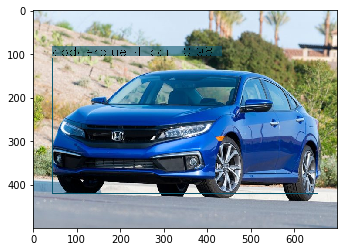

In [4]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.50
IOU_THRESHOLD = 0.3

# the neural network configuration
config_path = "./cfg/yolov3.cfg"
# the YOLO net weights file
weights_path = "./weights/yolov3.weights"
# weights_path = "weights/yolov3-tiny.weights"

# loading all the class labels (objects)
labels = open("./data/coco.names").read().strip().split("\n")
# generating colors for each object for later plotting
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# load the YOLO network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

path_name = "./test_images/10.jpg"
image = cv2.imread(path_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image= cv2.add(image,np.array([10.0]))
#print('Size of main image: ',image.shape)
copy_image = image.copy()
file_name = os.path.basename(path_name)
filename, ext = file_name.split(".")

print("It's working ...")
h, w = image.shape[:2]
# create 4D blob
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

# sets the blob as the input of the network
net.setInput(blob)
# get all the layer names
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# feed forward (inference) and get the network output
# measure how much it took in seconds
start = time.perf_counter()
layer_outputs = net.forward(ln)
time_took = time.perf_counter() - start
print(f"Time took: {time_took:.2f}s")

font_scale = 1
thickness = 1
boxes, confidences, class_ids = [], [], []
# loop over each of the layer outputs
for output in layer_outputs:
    # loop over each of the object detections
    for detection in output:
        # extract the class id (label) and confidence (as a probability) of
        # the current object detection
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # discard out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > CONFIDENCE:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
# perform the non maximum suppression given the scores defined before
idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)
clt = KMeans(n_clusters = 4)

def getColorName(R ,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname
vehicles =  ['car', 'motorbike', 'bus', 'truck', 'aeroplane']
#plt.imshow(image)
#plt.show()


# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        x, y = boxes[i][0], boxes[i][1]
        w, h = boxes[i][2], boxes[i][3]
        if i in idxs:
            if labels[class_ids[i]] in vehicles:
                copied_image = image.copy()
                x,y,w,h = boxes[i]
                scaleTop = int(h * 0.30) # scaling the top with the % 
                scaleBottom = int(h * 0.15)  # scaling the bottom with the % 
                x1 = x
                y1 = y + scaleTop
                x2 = x + w
                y2 = (y + h) - scaleBottom
                #print("x: {}, y: {}, w: {}, h: {}, scaleTop: {}, scaleBottom: {}".format(x,y, w, h, scaleTop, scaleBottom))
                #print("scaleTop:y + scaleBottom, x:x + w")
                crop_img = copied_image[y1:y2, x1:x2]
                #print(crop_img.shape)
                
                crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                crop_img = cv2.fastNlMeansDenoisingColored(crop_img,None,10,10,7,21)
                
                #cv2.imwrite(filename +  str(i) + "_Object." + ext, crop_img)
                pixels = crop_img.reshape((crop_img.shape[0] * crop_img.shape[1], 3))
                labelsinvehicle = clt.fit_predict(pixels)
                label_counts = Counter(labelsinvehicle)
                #subset out most popular centroid
                dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
                r, g, b = dominant_color
                color_present = getColorName(b, g, r)
        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in colors[class_ids[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
        if labels[class_ids[i]] in vehicles:
            text = f"{color_present} { labels[class_ids[i]]}: {confidences[i]:.2f} "
            print("Object - {}: {} - {}".format(i+1, dominant_color, text))
        else:
            text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
            print(text)
        # calculate text width & height to draw the transparent boxes as background of the text
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
        text_offset_x = x
        text_offset_y = y - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
        overlay = image.copy()
        
        #overlay = image = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
        # add opacity (transparency to the box)
        
        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
        
        # now put the text (label: confidence %)
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
        
plt.imshow(image)

plt.show()

<b> To view in a new window </b>

In [10]:
imageToShow = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imshow("image", imageToShow)
cv2.waitKey(0)

-1

<b>Saving file</b>

In [8]:
imageToSave = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite(filename + "_YOLO." + ext, imageToSave)

True

<h2> Reference </h2>


1. [Code for YOLO](https://www.thepythoncode.com/article/yolo-object-detection-with-opencv-and-pytorch-in-python)
2. [Detecting Color & `color.csv` file](https://data-flair.training/blogs/project-in-python-colour-detection/)
3. [Determining the dominant color](https://dev-qa.com/176799/as-in-opencv-to-determine-the-dominant-color)
4. [`another new_color.csv file`, as this gave higher accurate results](https://cloford.com/resources/colours/500col.htm)
5. [Color Picker to check if color matches](https://www.google.com/search?ei=-sD9XpvKCqC_3LUP97q5wA0&q=color+picker&oq=color+picker&gs_lcp=CgZwc3ktYWIQAzIECAAQRzIECAAQRzIECAAQRzIECAAQRzIECAAQRzIECAAQRzIECAAQRzIECAAQR1DoswJY6LMCYMO1AmgAcAF4AIABAIgBAJIBAJgBAKABAaoBB2d3cy13aXo&sclient=psy-ab&ved=0ahUKEwibr-XOt67qAhWgH7cAHXddDtgQ4dUDCAw&uact=5)
- [Denoising the image](https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html)

6. [DETECTING NUMBER PLATE](https://github.com/bhargav-polampalli/Automatic-Indian-Number-Plate-Recognition-System/blob/master/Main.py), [Another one](https://github.com/MicrocontrollersAndMore/OpenCV_3_License_Plate_Recognition_Python)
7. [Installing Tesseract](https://github.com/UB-Mannheim/tesseract)

In [24]:
x, y, w ,h

(133, 141, 60, 62)

Size of original image:  (500, 700, 3)


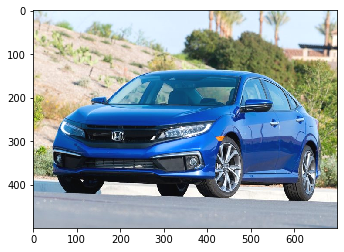

First crop without %:  (310, 610, 3)


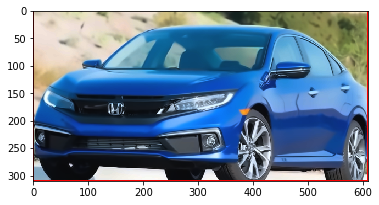

x: 44, y: 110, w: 610, h: 310, scaleTop: 93, scaleBottom: 46
It's working ...
Second crop with %:  (171, 610, 3)


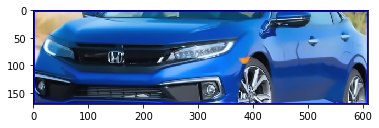

In [5]:
img = cv2.imread('./test_images/10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= cv2.add(img,np.array([10.0]))
print("Size of original image: ",img.shape)
plt.imshow(img)
plt.show()
#x, y, w, h = 44, 110, 610, 310
img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
first_img = img[y:y + h, x:x + w] # full bounding box
cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,0), thickness=2)
print("First crop without %: ",first_img.shape)
plt.imshow(first_img)
plt.show()


scaleTop = int(h * 0.30)
scaleBottom = int(h * 0.15)
print("x: {}, y: {}, w: {}, h: {}, scaleTop: {}, scaleBottom: {}".format(x,y, w, h, scaleTop, scaleBottom))
print("It's working ...")
x1 = x
y1 = y + scaleTop
x2 = x + w
y2 = (y + h) - scaleBottom
cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), thickness=3)
crop_img = img[y1: y2, x1:x2]
print("Second crop with %: ",crop_img.shape)
plt.imshow(crop_img)
plt.show()

In [ ]:
#image = cv2.imread('./test_images/1.jpeg')
image = crop_img.copy()
#image = cv2.imread('images/input.jpg')
# Create kernel
kernel = np.array([[0, -1, 0], 
                   [-1, 5,-1], 
                   [0, -1, 0]])

# Sharpen image
image_sharp = cv2.filter2D(image, -1, kernel)
plt.imshow(image_sharp)
plt.show()
#image = imutils.resize(image, width=500)

#cv2.imshow("Original Image", image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2.imshow("1 - Grayscale Conversion", gray)

gray = cv2.bilateralFilter(gray, 11, 17, 17)
#cv2.imshow("2 - Bilateral Filter", gray)

edged = cv2.Canny(gray, 170, 200)
#cv2.imshow("4 - Canny Edges", edged)

(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)#removed new
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:40]
NumberPlateCnt = None 

count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  
            NumberPlateCnt = approx 
            break

# Masking the part other than the number plate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(image,image,mask=mask)
#cv2.namedWindow("Final_image",cv2.WINDOW_NORMAL)
#cv2.imshow("Final_image",new_image)
#cv2.waitKey(0)
plt.imshow(new_image)
plt.show()

# Run tesseract OCR on image
text = pytesseract.image_to_string(new_image,)
print(text)

In [12]:
text

''